In [1]:
%load_ext autoreload
%autoreload 2

## Import modules and packages

In [2]:
import sys

sys.path.append("../../src")
import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle

## Creating a `stochastic_benchmark` object

The primary class we will use is the `stochastic_benchmark` class in the `stochastic_benchmark` module. This object orchestrates the entire benchmarking workflow.

### Configuration Parameters:

**Problem Parameters:**
- `parameter_names`: The algorithm parameters being tuned (e.g., iterations, shots, rounds)
- `instance_cols`: Columns used to group problem instances (default: `['instance']`)

**Response Configuration:**
- `response_key`: The column containing the optimization objective (e.g., `approx_ratio`)
- `response_dir`: Optimization direction - use `1` for maximization, `-1` for minimization

**Performance Optimizations:**
- `recover`: If `True`, loads existing dataframes when available instead of recomputing
- `reduce_mem`: If `True`, uses memory-efficient segmented processing for bootstrap and interpolation
- `smooth`: If `True`, ensures the virtual best performance curve is monotone (non-decreasing for maximization)

Run the cell below to instantiate the benchmark object with these configurations.

In [3]:
# Working directory for storing checkpoints and results
here = os.getcwd()

# Algorithm parameters to analyze across different resource levels
# These are the "knobs" we can tune to improve performance
parameter_names = [
    "iterations",  # Number of COBYLA optimizer iterations
    "shots",       # Number of quantum circuit measurements per iteration
    "rounds",      # Number of QAOA rounds (p parameter)
]

# Column(s) defining unique problem instances
# Each unique value identifies a separate optimization problem
instance_cols = ["instance"]

# ============================================================
# Response Configuration
# ============================================================
response_key = "approx_ratio"  # Optimization objective to maximize
response_dir = 1               # 1 = maximize, -1 = minimize

# ============================================================
# Performance Options
# ============================================================
recover = True     # Load cached results when available (faster restarts)
reduce_mem = True  # Use memory-efficient processing for large datasets
smooth = True      # Enforce monotone virtual best curve

# Create the stochastic_benchmark object
sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    response_dir=response_dir,
    smooth=smooth,
)

## Load Bootstrap Data

Bootstrap resampling quantifies the uncertainty in performance measurements by creating multiple resampled datasets. This provides confidence intervals for the approximation ratio at each resource level.

### What happens in this step:
- **Loads pre-computed bootstrap data** from the `checkpoints` folder (for 10 problem instances)
- **Computes confidence intervals** at the specified confidence level (68% ≈ 1 standard deviation)
- **Iterates over multiple restart counts** to understand performance vs. computational budget tradeoffs

### Configuration:
- `boots_range = [1, 2, 5, 10, 20, 50, 100]`: Number of algorithm restarts to analyze
- `confidence_level = 68`: Confidence level for intervals (68% ≈ ±1σ, 95% ≈ ±2σ)
- `response_col = "approx_ratio"`: The performance metric being bootstrapped
- `resource_col = "resource"`: The computational budget measure

**Note:** In practice, you would generate bootstrap data from raw experimental runs. Here we load pre-computed results for efficiency.

In [4]:
# ============================================================
# Bootstrap Configuration
# ============================================================
# Common arguments for all bootstrap computations
shared_args = {
    "response_col": "approx_ratio",  # Performance metric to bootstrap
    "resource_col": "resource",      # Computational budget column
    "response_dir": 1,               # 1 = maximize performance
    "confidence_level": 68,          # Confidence level for intervals (68% ≈ ±1σ)
}

# Range of restart counts to analyze
# Explores tradeoff: few restarts (fast) vs many restarts (better statistics)
boots_range = [1, 2, 5, 10, 20, 50, 100]

# Create bootstrap parameters object
# update_rule allows custom transformations; None = use data as-is
bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args, 
    update_rule=lambda df: None  # No preprocessing needed
)

# Create iterator to process each restart count
bs_iter_class = bootstrap.BSParams_range_iter()
bsParams_iter = bs_iter_class(bsParams, boots_range)

# Load and process bootstrap data from checkpoints
# Results stored in sb.boots_results (accessible after this call)
sb.run_Bootstrap(bsParams_iter)

Loading and bootstrapping experimental data...


## Interpolation: Creating a Common Resource Grid

Different experimental runs may have data at different resource levels, making direct comparison difficult. Interpolation creates estimates at a common grid of resource values across all instances.

### Why Interpolation?
- **Alignment**: Ensures all instances have performance estimates at the same resource levels
- **Comparison**: Enables fair comparison across instances with different sampling patterns
- **Visualization**: Makes plotting and analysis more straightforward

### Defining "Resource"
For QAOA, we measure computational resources as the **total number of quantum circuit evaluations**:

$$\text{Resource} = \text{boots} \times \text{iterations} \times \text{shots}$$

Where:
- `boots`: Number of algorithm restarts (bootstrap samples)
- `iterations`: Number of classical optimizer (COBYLA) iterations
- `shots`: Number of quantum circuit measurements per iteration

**Alternative resource definitions** could include:
- Wall-clock time
- QPU time (quantum processing unit time)
- Total number of gates executed

### Output
Results are saved to `checkpoints/interpolated_results.pkl` and accessible via `sb.interp_results`.

In [5]:
# ============================================================
# Define Resource Metric
# ============================================================
def resource_fcn(df):
    """
    Calculate total quantum circuit evaluations as the resource metric.
    
    Resource = (restarts) × (optimizer iterations) × (measurements per iteration)
    
    This represents the total number of times we queried the quantum hardware.
    """
    return df["boots"] * df["iterations"] * df["shots"]


# ============================================================
# Configure and Run Interpolation
# ============================================================
# Create interpolation parameters
# - resource_fcn: Function defining what "resource" means for this problem
# - parameters: Which algorithm parameters to interpolate alongside performance
iParams = interpolate.InterpolationParameters(
    resource_fcn, 
    parameters=parameter_names  # interpolate iterations, shots, rounds
)

# Execute interpolation across all instances
# Creates a common resource grid for fair comparison
# Results: sb.interp_results DataFrame with aligned resource levels
sb.run_Interpolate(iParams)

Interpolating results across resource budgets...


100%|██████████| 540/540 [00:00<00:00, 846.97it/s] 



## Train/Test Split and Statistical Aggregation

To evaluate parameter recommendation strategies, we split instances into **training** (for learning parameter strategies) and **testing** (for evaluating recommendations) sets.

### What This Step Does:

1. **Splits instances** into train (80%) and test (20%) sets
2. **Computes aggregate statistics** separately for each set
3. **Saves results** to checkpoint files for later analysis

### Train vs. Test Sets:
- **Training set** (80%): Used to learn which parameters work well across instances
- **Testing set** (20%): Used to evaluate how well recommendations generalize to new instances

### Statistical Measures:
By default, we compute the **median** across instances, which is robust to outliers. Alternative options include:
- `stats.Mean()`: Average performance (sensitive to outliers)
- `stats.Quantile(q)`: Custom quantile (e.g., 25th, 75th percentile)
- Multiple measures can be combined: `[stats.Mean(), stats.Median()]`

### Output Files:
- `checkpoints/interpolated_results.pkl`: Updated with `train` column
- `checkpoints/testing_stats.pkl`: Statistics for test set → `sb.testing_stats`
- `checkpoints/training_stats.pkl`: Statistics for training set → `sb.training_stats`

In [6]:
# ============================================================
# Configure Train/Test Split and Statistics
# ============================================================

# Split ratio: 80% training instances, 20% testing instances
train_test_split = 0.8

# Metrics to compute statistics for
# These are the response columns from the interpolated results
metrics = ["approx_ratio"]  # Could include additional metrics if available

# Statistical measures to compute across instances
# Median is robust to outliers; alternatives: stats.Mean(), stats.Quantile(0.75)
stParams = stats.StatsParameters(
    metrics=metrics,                    # Which response columns to aggregate
    stats_measures=[stats.Median()]     # How to aggregate (median, mean, etc.)
)

# ============================================================
# Execute Statistics Computation
# ============================================================
# This will:
# 1. Add 'train' column to sb.interp_results (True/False for each instance)
# 2. Compute aggregate statistics for training and testing sets separately
# 3. Save results to testing_stats.pkl and training_stats.pkl
sb.run_Stats(stParams, train_test_split)

# Results accessible as:
# - sb.testing_stats: Statistics for test instances
# - sb.training_stats: Statistics for training instances

Computing training/testing statistics...


100%|██████████| 20895/20895 [00:10<00:00, 1913.51it/s]


## Virtual Best Baseline: Oracle Performance Upper Bound

The **Virtual Best** baseline establishes an **oracle** upper bound on performance by computing the best parameters *for each individual test instance* at each resource level. This represents the best possible performance if we had perfect knowledge of which parameters work best for each specific problem instance.

### What "Virtual Best" Means:

For each test instance at each resource level:
1. **Examines all parameter configurations** that were tried
2. **Selects the configuration** that achieved the best performance
3. **Records both the performance and the parameters** that achieved it

This is "virtual" because in practice we don't know which parameters are best until after we've tried them. It represents an **unachievable upper bound** that helps us evaluate how close parameter recommendation strategies can get to optimal performance.

### Use Case:
The Virtual Best serves as a **gold standard comparison** for evaluating parameter recommendation strategies:
- If a recommendation strategy achieves 90% of Virtual Best performance, it's doing very well
- If it only achieves 50%, there's significant room for improvement

### Implementation Details:
- **Operates only on test instances** (the 20% held-out set)
- **Smoothing**: If enabled, ensures performance curves are monotone (non-decreasing with more resources)
- **Per-instance**: Each test instance gets its own best parameters at each resource level

### Output:
- **File**: `checkpoints/VirtualBest_test.pkl`
- **Accessible via**: `sb.baseline.rec_params` (DataFrame with best parameters per instance and resource)
- **Columns**: resource, parameter values, performance, confidence intervals

In [7]:
# ============================================================
# Compute Virtual Best Baseline (Oracle Upper Bound)
# ============================================================
# For each test instance at each resource level, find the parameter configuration
# that achieved the best performance. This represents perfect hindsight and serves
# as an upper bound for evaluating parameter recommendation strategies.
#
# Process:
# 1. Filter to test instances only (train=0)
# 2. For each (instance, resource) pair, select best-performing parameters
# 3. Apply smoothing if enabled (monotone performance with increasing resources)
# 4. Save results to checkpoints/VirtualBest_test.pkl
#
# Output accessible via:
# - sb.baseline: VirtualBestBaseline object
# - sb.baseline.rec_params: DataFrame with (instance, resource, params, performance)
sb.run_baseline()

Computing virtual best baseline...


## Projection Experiments: Evaluating Parameter Recommendation Strategies

**Projection experiments** evaluate how well parameter recommendations learned from the training set perform when applied to the test set. This simulates the real-world scenario where we learn a parameter strategy from some instances and apply it to new, unseen instances.

### The Two Projection Strategies:

#### 1. **Projection from TrainingStats** (Aggregate-then-Recommend)
**Philosophy**: Learn a single parameter recipe by aggregating statistics across all training instances.

**Process**:
1. Compute **median performance** across all training instances at each resource level
2. Select the parameter configuration that achieves the **best median performance** at each resource
3. Recommend these "best on average" parameters to all test instances

**Use case**: When you believe there's a universal parameter setting that works well across most instances.

**Saved as**: `checkpoints/BestRecommended_train.pkl`

---

#### 2. **Projection from TrainingResults** (Instance-Specific-then-Average)
**Philosophy**: Learn what works best for each training instance individually, then average those recommendations.

**Process**:
1. For each training instance, find its **Virtual Best parameters** (best configuration per instance)
2. **Average the best parameters** across all training instances at each resource level
3. Recommend these averaged parameters to all test instances

**Use case**: When different instances prefer different parameters, but you want to capture the "typical" best configuration.

**Saved as**: `checkpoints/VirtualBest_train.pkl` → averaged recipe

---

### Key Difference:
- **TrainingStats**: Best parameters for the **aggregate statistic** (e.g., median across instances)
- **TrainingResults**: **Aggregated best parameters** (e.g., average of each instance's best)

These can differ significantly! TrainingStats optimizes collective performance, while TrainingResults captures instance-specific preferences.

### What Happens Next:
For each test instance, the framework:
1. **Projects** the recommended parameters onto the test instance's data
2. **Evaluates** the performance achieved by following those recommendations
3. **Compares** against the Virtual Best baseline to measure recommendation quality

### Output:
Results stored in `sb.experiments[]` list and saved to:
- `checkpoints/params_plotting/Projection from TrainingStats.csv`
- `checkpoints/params_plotting/Projection from TrainingResults.csv`

In [8]:
# ============================================================
# Projection Experiment 1: From TrainingStats (Aggregate-then-Recommend)
# ============================================================
# Strategy: Find parameters that maximize the AGGREGATE statistic (median) across
# all training instances, then recommend those parameters to test instances.
#
# Steps:
# 1. Use training_stats (median performance across training instances)
# 2. At each resource level, find parameters with best median performance
# 3. Project these "best for the group" parameters onto test instances
# 4. Evaluate how well this strategy performs on test set
#
# This answers: "What parameters work best for the AVERAGE instance?"
sb.run_ProjectionExperiment("TrainingStats", None, None)

# ============================================================
# Projection Experiment 2: From TrainingResults (Instance-Specific-then-Average)
# ============================================================
# Strategy: For each training instance, find its BEST parameters (Virtual Best),
# then AVERAGE those best parameters across instances and recommend to test set.
#
# Steps:
# 1. Compute Virtual Best for each training instance (best params per instance)
# 2. Average these best parameters across all training instances
# 3. Project these "averaged best" parameters onto test instances
# 4. Evaluate how well this strategy performs on test set
#
# This answers: "What parameters are typically best for individual instances?"
sb.run_ProjectionExperiment("TrainingResults", None, None)

# ============================================================
# Key Difference:
# ============================================================
# TrainingStats:   best(median(instances))  → optimize for the group
# TrainingResults: mean(best(each_instance)) → average of individual optima
#
# These can recommend DIFFERENT parameters! TrainingStats finds parameters that
# work well collectively, while TrainingResults captures instance-specific preferences.

  ├─ Running ProjectionExperiment from TrainingStats...
  ├─ Running ProjectionExperiment from TrainingResults...
  ├─ Running ProjectionExperiment from TrainingResults...


## Visualization Setup: Initialize Plotting Framework

Now that all experiments are complete (baseline and projection experiments), we can visualize the results. This cell configures the plotting framework and prepares it to generate comparison plots.

### What This Step Does:

1. **Sets monotone enforcement**: `plotting.monotone = True` ensures all performance curves are non-decreasing
2. **Initializes plotting object**: `sb.initPlotting()` creates the `Plotting` helper that coordinates all visualizations

### Monotone Enforcement (`plotting.monotone = True`):

When enabled, this ensures that performance curves are **monotone non-decreasing** with respect to resources:
- **Rationale**: With more computational resources, performance should never get worse
- **Effect**: Smooths out noise and statistical fluctuations in the data
- **Implementation**: For each resource level, takes the maximum performance seen up to that point

**Example**: If raw data shows performance [0.7, 0.8, 0.75, 0.85], monotone version becomes [0.7, 0.8, 0.8, 0.85]

### The Plotting Object (`sb.plots`):

Creates a `Plotting` instance that:
- **Assigns colors** to each experiment (baseline always black)
- **Sets up shared axes** (log scale for resources, common x-axis limits)
- **Prepares data** for performance and parameter plots
- **Manages legends** and styling consistently across plots

### Available Plotting Methods:

After initialization, you can call:
- `sb.plots.plot_performance()`: Compare performance across all experiments
- `sb.plots.plot_parameters_separate()`: Individual plots for each parameter
- `sb.plots.plot_parameters_together()`: Combined plot showing all parameters
- `sb.plots.plot_parameters_distance()`: Distance from recommended to optimal parameters

### Output Storage:

Plots save processed data to checkpoint folders for faster re-plotting:
- `checkpoints/performance_plotting/`: Performance curves for each experiment
- `checkpoints/params_plotting/`: Parameter recommendations for each experiment

In [9]:
# ============================================================
# Configure Plotting Settings
# ============================================================
import plotting

# Enable monotone enforcement: ensures performance curves never decrease
# with more resources (smooths out statistical noise and fluctuations)
# Set to False if you want to see raw, unsmoothed performance curves
plotting.monotone = True

# Control whether to plot confidence intervals for Virtual Best baseline
# Default: True (shows uncertainty in baseline performance)
# plotting.plot_vb_CI = False  # Uncomment to hide baseline confidence intervals

# ============================================================
# Initialize Plotting Framework
# ============================================================
# Creates the plotting object that coordinates all visualizations:
# - Assigns colors to experiments (baseline = black, experiments = color palette)
# - Sets up shared axes (log scale for resources)
# - Prepares data structures for performance and parameter plots
# - Manages legends and styling
sb.initPlotting()

# After this, plotting methods are available via sb.plots:
# - sb.plots.plot_performance()           → performance comparison
# - sb.plots.plot_parameters_separate()   → individual parameter plots
# - sb.plots.plot_parameters_together()   → combined parameter plot
# - sb.plots.set_xlims((min, max))        → set custom x-axis limits
# - sb.plots.set_colors(palette)          → customize color palette

## Performance Comparison Plot

This plot compares the **approximation ratio** (performance) achieved by each parameter recommendation strategy across different resource levels.

### What This Plot Shows:

**Y-axis**: Approximation ratio (performance metric)  
**X-axis**: Computational resources (log scale) — total quantum circuit evaluations

**Curves displayed**:
- **Virtual Best (black)**: Oracle upper bound — best possible performance with perfect hindsight
- **Projection from TrainingStats (colored)**: Performance using aggregate-then-recommend strategy
- **Projection from TrainingResults (colored)**: Performance using instance-specific-then-average strategy

### Visual Elements:

- **Lines with markers**: Median performance across test instances at each resource level
- **Shaded regions**: Confidence intervals (68% by default) showing uncertainty
- **Monotone curves**: If `plotting.monotone = True`, curves never decrease with more resources

### Interpreting the Results:

**Good recommendation strategy** → Curve close to Virtual Best baseline  
**Gap from baseline** → Room for improvement in parameter recommendations  
**Narrow confidence intervals** → Consistent performance across test instances  
**Wide confidence intervals** → High variability in how well recommendations work

This plot answers: *"How close do our parameter recommendations get to optimal performance?"*

100%|██████████| 100/100 [00:00<00:00, 2600.60it/s]



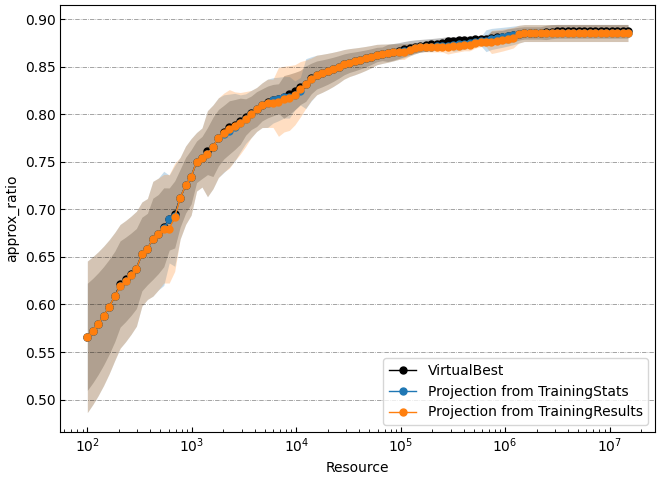

In [10]:
# ============================================================
# Generate Performance Comparison Plot
# ============================================================
# Creates a single plot comparing all experiments' performance vs. resources
# - Black curve: Virtual Best baseline (oracle upper bound)
# - Colored curves: Each projection experiment
# - Shaded regions: Confidence intervals (default 68%)
# - Log scale x-axis for resource levels
fig, axs = sb.plots.plot_performance()

# Optionally save the figure to a file
# fig.savefig("performance.png")  # Uncomment to save plot as PNG
# fig.savefig("performance.pdf")  # Uncomment to save plot as PDF

# The plot displays in the notebook automatically
# Data is cached to: checkpoints/performance_plotting/

## Individual Parameter Plots (Separate)

These plots show how each **algorithm parameter** evolves with increasing computational resources, displayed on separate subplots for clarity.

### What These Plots Show:

**One plot per parameter**:
- **iterations**: Number of COBYLA optimizer iterations
- **shots**: Number of quantum circuit measurements per iteration  
- **rounds**: Number of QAOA layers (p parameter)

**For each parameter plot**:
- **Y-axis**: Parameter value (recommended or optimal)
- **X-axis**: Computational resources (log scale) — total quantum circuit evaluations

**Curves displayed**:
- **Virtual Best (black)**: Optimal parameter values from oracle (per-instance best)
- **Projection experiments (colored)**: Recommended parameter values from each strategy

### Visual Elements:

- **Lines with color gradients**: Parameter values colored by performance (approximation ratio)
  - **Darker colors**: Better performance at that resource level
  - **Lighter colors**: Worse performance
- **Separate subplots**: Each parameter gets its own plot for easy comparison

### Interpreting the Results:

**Recommendations close to Virtual Best** → Strategy learned good parameter values  
**Divergence from baseline** → Strategy recommending suboptimal parameters  
**Parameter trends** → How parameters should scale with resources (e.g., more shots at low resources)  
**Color patterns** → Which parameter values lead to better performance

This plot answers: *"Are we recommending the right parameter values, and how should they change with resources?"*

100%|██████████| 100/100 [00:00<00:00, 2565.79it/s]



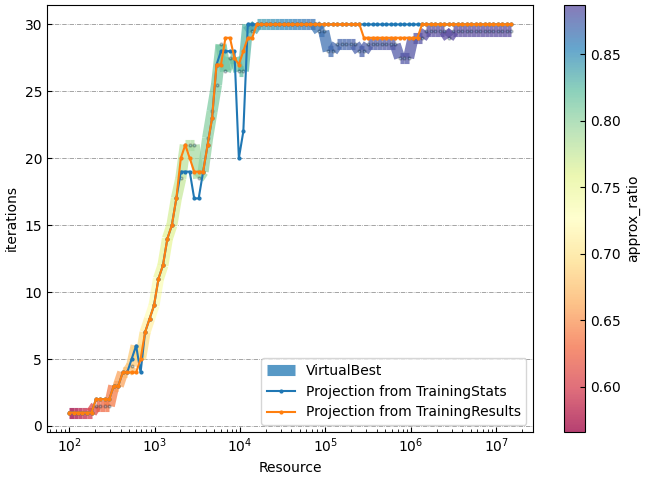

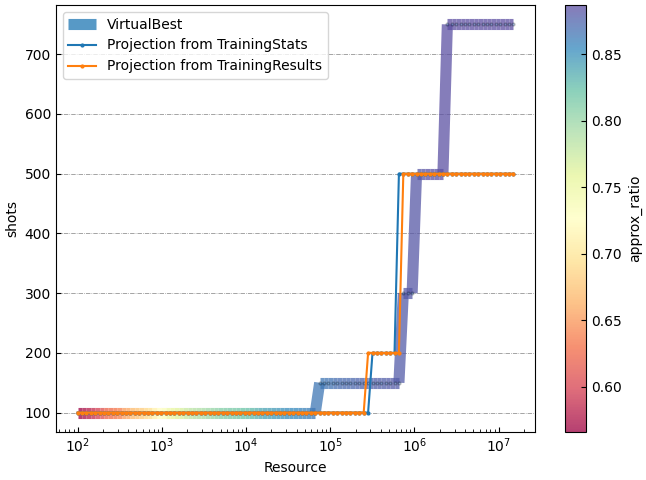

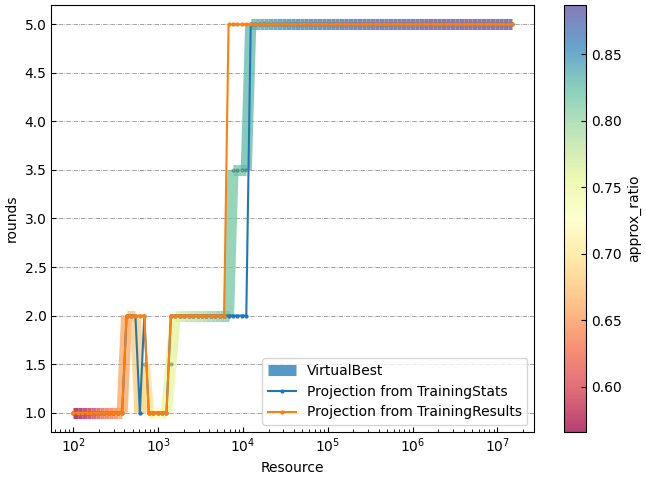

In [11]:
# ============================================================
# Generate Individual Parameter Plots
# ============================================================
# Creates separate plots for each parameter (iterations, shots, rounds)
# showing how recommended values evolve with resources
# - Black curves: Virtual Best optimal parameter values (per-instance)
# - Colored curves: Recommended parameter values from each experiment
# - Color gradient on curves: Represents performance (darker = better)
# - Returns dictionary: {parameter_name: figure}
figs, axes = sb.plots.plot_parameters_separate()

# Optionally save each parameter plot to individual files
# for param, fig in figs.items():
#     fig.savefig(param + ".png")  # Uncomment to save as PNG
#     # fig.savefig(param + ".pdf")  # Or save as PDF

# The plots display in the notebook automatically
# Data is cached to: checkpoints/params_plotting/

## Combined Parameter Plot (Together)

This plot displays **all algorithm parameters together** on a single figure with subplots, making it easy to see how the entire parameter configuration evolves with resources.

### What This Plot Shows:

**Layout**: Multiple subplots on one figure, each showing a different parameter:
- **iterations**: COBYLA optimizer iterations
- **shots**: Quantum circuit measurements per iteration
- **rounds**: QAOA layers (p parameter)

**For each subplot**:
- **Y-axis**: Parameter value (recommended or optimal)
- **X-axis**: Computational resources (log scale) — total quantum circuit evaluations
- **Shared x-axis**: All subplots aligned for easy comparison across parameters

**Curves displayed**:
- **Virtual Best (black)**: Optimal parameter values from oracle
- **Projection experiments (colored)**: Recommended parameter values from each strategy

### Visual Elements:

- **Synchronized x-axes**: Same resource levels across all parameter subplots
- **Consistent color scheme**: Same color represents same experiment across all subplots
- **Compact layout**: All parameters visible at once for holistic view

### Interpreting the Results:

**Parameter coordination** → See how all parameters change together with resources  
**Resource allocation** → Understand tradeoffs (e.g., more shots vs. more iterations)  
**Strategy comparison** → Quickly compare how different strategies recommend different parameter combinations  
**Scaling patterns** → Identify which parameters scale linearly vs. remain constant

### Use Case:

This plot is ideal for:
- **Publications and presentations**: Compact visualization of complete parameter recommendations
- **Strategy comparison**: Quickly assess which strategy makes sensible parameter recommendations
- **Resource budgeting**: Understand how to allocate computational budget across parameters

This plot answers: *"How should I configure all parameters together as my computational budget changes?"*

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2423.84it/s]



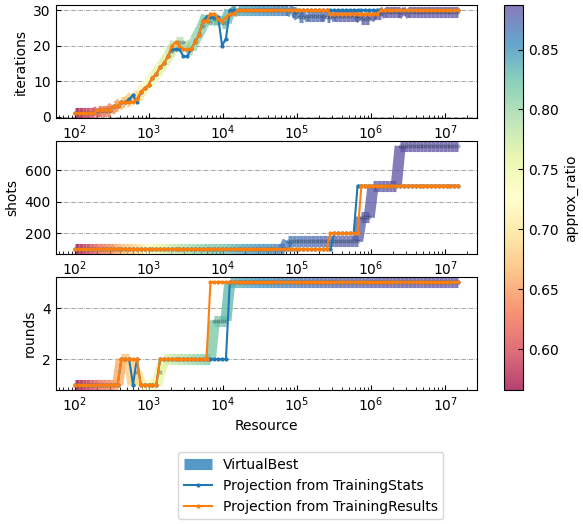

In [12]:
# ============================================================
# Generate Combined Parameter Plot
# ============================================================
# Creates a single figure with subplots for all parameters
# showing how the complete parameter configuration evolves with resources
# - Black curves: Virtual Best optimal parameter values
# - Colored curves: Recommended parameter values from each experiment
# - Shared x-axis: All subplots aligned at same resource levels
# - Compact layout: All parameters visible at once
fig, axes = sb.plots.plot_parameters_together()

# Optionally save the combined figure to a file
# fig.savefig("all_params.png")  # Uncomment to save plot as PNG
# fig.savefig("all_params.pdf")  # Uncomment to save plot as PDF

# The plot displays in the notebook automatically
# Data is cached to: checkpoints/params_plotting/

In [13]:
# ============================================================
# Extract Performance Metrics from Results
# ============================================================
# Read the saved CSV files to extract actual performance values
# for the conclusions section below

import pandas as pd
import numpy as np

# Load performance data from checkpoints
perf_dir = os.path.join(here, "checkpoints", "performance_plotting")
params_dir = os.path.join(here, "checkpoints", "params_plotting")

# Read Virtual Best baseline performance
vb_perf = pd.read_csv(os.path.join(perf_dir, "baseline.csv"))

# Read projection experiment performances
try:
    proj_stats_perf = pd.read_csv(os.path.join(perf_dir, "Projection from TrainingStats.csv"))
except:
    proj_stats_perf = None

try:
    proj_results_perf = pd.read_csv(os.path.join(perf_dir, "Projection from TrainingResults.csv"))
except:
    proj_results_perf = None

# Read parameter recommendations
vb_params = pd.read_csv(os.path.join(params_dir, "baseline.csv"))

# Define resource levels of interest
resource_levels = [1e2, 1e3, 1e4, 1e5, 1e6]

# Helper function to get value at closest resource level
def get_value_at_resource(df, resource, column='response'):
    """Get value from dataframe at closest resource level."""
    if df is None or len(df) == 0:
        return None
    idx = (df['resource'] - resource).abs().idxmin()
    return df.loc[idx, column]

# Extract performance metrics at each resource level
print("=" * 60)
print("QAOA PERFORMANCE METRICS")
print("=" * 60)
print("\nVirtual Best (Oracle Upper Bound):")
print("-" * 60)

for resource in resource_levels:
    approx_ratio = get_value_at_resource(vb_perf, resource, 'response')
    ci_lower = get_value_at_resource(vb_perf, resource, 'response_lower')
    ci_upper = get_value_at_resource(vb_perf, resource, 'response_upper')
    
    if approx_ratio is not None:
        ci_range = ci_upper - ci_lower if ci_upper and ci_lower else 0
        print(f"At {resource:.0e} evaluations: {approx_ratio:.4f} ± {ci_range/2:.4f}")
        
        # Get optimal parameters at this resource level
        shots = get_value_at_resource(vb_params, resource, 'shots')
        iterations = get_value_at_resource(vb_params, resource, 'iterations')
        rounds_val = get_value_at_resource(vb_params, resource, 'rounds')
        
        if all(v is not None for v in [shots, iterations, rounds_val]):
            print(f"  Optimal params: shots≈{shots:.0f}, iterations≈{iterations:.0f}, rounds≈{rounds_val:.1f}")

# Compare projection strategies
if proj_stats_perf is not None or proj_results_perf is not None:
    print("\n" + "=" * 60)
    print("RECOMMENDATION STRATEGY PERFORMANCE")
    print("=" * 60)
    
    if proj_stats_perf is not None:
        print("\nProjection from TrainingStats:")
        print("-" * 60)
        for resource in resource_levels:
            approx_ratio = get_value_at_resource(proj_stats_perf, resource, 'response')
            vb_ratio = get_value_at_resource(vb_perf, resource, 'response')
            
            if approx_ratio is not None and vb_ratio is not None:
                gap = vb_ratio - approx_ratio
                pct_of_vb = (approx_ratio / vb_ratio * 100) if vb_ratio > 0 else 0
                print(f"At {resource:.0e}: {approx_ratio:.4f} ({pct_of_vb:.1f}% of VB, gap: {gap:.4f})")
    
    if proj_results_perf is not None:
        print("\nProjection from TrainingResults:")
        print("-" * 60)
        for resource in resource_levels:
            approx_ratio = get_value_at_resource(proj_results_perf, resource, 'response')
            vb_ratio = get_value_at_resource(vb_perf, resource, 'response')
            
            if approx_ratio is not None and vb_ratio is not None:
                gap = vb_ratio - approx_ratio
                pct_of_vb = (approx_ratio / vb_ratio * 100) if vb_ratio > 0 else 0
                print(f"At {resource:.0e}: {approx_ratio:.4f} ({pct_of_vb:.1f}% of VB, gap: {gap:.4f})")

# Calculate performance improvements
print("\n" + "=" * 60)
print("PERFORMANCE IMPROVEMENTS")
print("=" * 60)

prev_approx = None
for i, resource in enumerate(resource_levels):
    approx_ratio = get_value_at_resource(vb_perf, resource, 'response')
    if approx_ratio is not None:
        if prev_approx is not None:
            improvement = ((approx_ratio - prev_approx) / prev_approx * 100)
            print(f"{resource_levels[i-1]:.0e} → {resource:.0e}: +{improvement:.2f}% improvement")
        prev_approx = approx_ratio

# Strategy comparison
if proj_stats_perf is not None and proj_results_perf is not None:
    print("\n" + "=" * 60)
    print("STRATEGY COMPARISON")
    print("=" * 60)
    
    for resource in [1e3, 1e4, 1e5]:
        stats_ratio = get_value_at_resource(proj_stats_perf, resource, 'response')
        results_ratio = get_value_at_resource(proj_results_perf, resource, 'response')
        
        if stats_ratio is not None and results_ratio is not None:
            diff = abs(stats_ratio - results_ratio)
            print(f"At {resource:.0e}: |TrainingStats - TrainingResults| = {diff:.4f}")
            
            if diff < 0.02:
                print(f"  → Small difference: Universal parameters work well")
            elif diff > 0.05:
                print(f"  → Large difference: Instance-specific tuning beneficial")
            else:
                print(f"  → Moderate difference: Consider problem characteristics")

print("\n" + "=" * 60)

QAOA PERFORMANCE METRICS

Virtual Best (Oracle Upper Bound):
------------------------------------------------------------
At 1e+02 evaluations: 0.5660 ± 0.0563
  Optimal params: shots≈100, iterations≈1, rounds≈1.0
At 1e+03 evaluations: 0.7340 ± 0.0285
  Optimal params: shots≈100, iterations≈9, rounds≈1.0
At 1e+04 evaluations: 0.8243 ± 0.0196
  Optimal params: shots≈100, iterations≈26, rounds≈3.5
At 1e+05 evaluations: 0.8668 ± 0.0084
  Optimal params: shots≈150, iterations≈30, rounds≈5.0
At 1e+06 evaluations: 0.8813 ± 0.0067
  Optimal params: shots≈300, iterations≈28, rounds≈5.0

RECOMMENDATION STRATEGY PERFORMANCE

Projection from TrainingStats:
------------------------------------------------------------
At 1e+02: 0.5660 (100.0% of VB, gap: 0.0000)
At 1e+03: 0.7340 (100.0% of VB, gap: 0.0000)
At 1e+04: 0.8197 (99.4% of VB, gap: 0.0046)
At 1e+05: 0.8657 (99.9% of VB, gap: 0.0010)
At 1e+06: 0.8808 (99.9% of VB, gap: 0.0005)

Projection from TrainingResults:
-----------------------------

In [14]:
# ============================================================
# Generate Filled Conclusions with Actual Data
# ============================================================
# This cell creates a markdown summary with actual performance values
# extracted from the analysis above

from IPython.display import Markdown

# Build the conclusions with actual data
conclusions_md = f"""
## Summary of Results with Actual Performance Data

### Virtual Best Performance (Oracle Upper Bound)

The table below shows the **best achievable approximation ratio** at each resource level:

| Resource Level | Approximation Ratio | Confidence Interval | Optimal Parameters |
|----------------|--------------------:|--------------------:|:-------------------|
"""

# Add rows for each resource level
for resource in resource_levels:
    approx_ratio = get_value_at_resource(vb_perf, resource, 'response')
    ci_lower = get_value_at_resource(vb_perf, resource, 'response_lower')
    ci_upper = get_value_at_resource(vb_perf, resource, 'response_upper')
    
    if approx_ratio is not None:
        ci_range = (ci_upper - ci_lower) / 2 if (ci_upper and ci_lower) else 0
        
        # Get parameters
        shots = get_value_at_resource(vb_params, resource, 'shots')
        iterations = get_value_at_resource(vb_params, resource, 'iterations')
        rounds_val = get_value_at_resource(vb_params, resource, 'rounds')
        
        param_str = f"s≈{shots:.0f}, i≈{iterations:.0f}, r≈{rounds_val:.1f}" if all(v is not None for v in [shots, iterations, rounds_val]) else "N/A"
        
        conclusions_md += f"| {resource:.0e} | {approx_ratio:.4f} | ±{ci_range:.4f} | {param_str} |\n"

# Add performance improvements
conclusions_md += f"""

### Performance Improvements Between Resource Levels

"""

prev_approx = None
for i, resource in enumerate(resource_levels):
    approx_ratio = get_value_at_resource(vb_perf, resource, 'response')
    if approx_ratio is not None:
        if prev_approx is not None:
            improvement = ((approx_ratio - prev_approx) / prev_approx * 100)
            conclusions_md += f"- **{resource_levels[i-1]:.0e} → {resource:.0e}**: +{improvement:.2f}% improvement\n"
        prev_approx = approx_ratio

# Add recommendation strategy performance
if proj_stats_perf is not None or proj_results_perf is not None:
    conclusions_md += f"""

### Recommendation Strategy Performance

**How close do recommendations get to optimal (Virtual Best)?**

"""
    
    if proj_stats_perf is not None and proj_results_perf is not None:
        conclusions_md += "| Resource | TrainingStats | % of VB | TrainingResults | % of VB | Difference |\n"
        conclusions_md += "|----------|-------------:|--------:|----------------:|--------:|-----------:|\n"
        
        for resource in [1e3, 1e4, 1e5]:
            vb_ratio = get_value_at_resource(vb_perf, resource, 'response')
            stats_ratio = get_value_at_resource(proj_stats_perf, resource, 'response')
            results_ratio = get_value_at_resource(proj_results_perf, resource, 'response')
            
            if all(v is not None for v in [vb_ratio, stats_ratio, results_ratio]):
                stats_pct = (stats_ratio / vb_ratio * 100) if vb_ratio > 0 else 0
                results_pct = (results_ratio / vb_ratio * 100) if vb_ratio > 0 else 0
                diff = abs(stats_ratio - results_ratio)
                
                conclusions_md += f"| {resource:.0e} | {stats_ratio:.4f} | {stats_pct:.1f}% | {results_ratio:.4f} | {results_pct:.1f}% | {diff:.4f} |\n"

# Add interpretation
conclusions_md += f"""

### Key Insights

"""

# Determine sweet spot (where improvement rate drops)
improvements = []
for i in range(1, len(resource_levels)):
    prev_approx = get_value_at_resource(vb_perf, resource_levels[i-1], 'response')
    curr_approx = get_value_at_resource(vb_perf, resource_levels[i], 'response')
    if prev_approx is not None and curr_approx is not None:
        improvements.append((resource_levels[i], (curr_approx - prev_approx) / prev_approx * 100))

if len(improvements) > 0:
    # Find where improvement drops below threshold
    sweet_spot_idx = next((i for i, (r, imp) in enumerate(improvements) if imp < 5.0), len(improvements)-1)
    sweet_spot = improvements[sweet_spot_idx][0]
    
    conclusions_md += f"""
**Recommended Resource Budget**: ~{sweet_spot:.0e} circuit evaluations
- At this level, you get substantial performance while avoiding diminishing returns
- Performance: ~{get_value_at_resource(vb_perf, sweet_spot, 'response'):.4f} approximation ratio
"""

# Strategy recommendation
if proj_stats_perf is not None and proj_results_perf is not None:
    avg_diff = np.mean([
        abs(get_value_at_resource(proj_stats_perf, r, 'response') - 
            get_value_at_resource(proj_results_perf, r, 'response'))
        for r in [1e3, 1e4, 1e5]
        if get_value_at_resource(proj_stats_perf, r, 'response') is not None
        and get_value_at_resource(proj_results_perf, r, 'response') is not None
    ])
    
    if avg_diff < 0.02:
        strategy_rec = "**TrainingStats** (universal parameters work well - difference < 0.02)"
    elif avg_diff > 0.05:
        strategy_rec = "**TrainingResults** (instance-specific tuning beneficial - difference > 0.05)"
    else:
        strategy_rec = "**Either strategy** (moderate difference suggests both are viable)"
    
    conclusions_md += f"""

**Recommended Strategy**: {strategy_rec}
- Average difference between strategies: {avg_diff:.4f}
"""

# Comparison to classical
vb_at_1e5 = get_value_at_resource(vb_perf, 1e5, 'response')
if vb_at_1e5 is not None:
    gw_ratio = 0.878  # Goemans-Williamson for Max-Cut
    
    if vb_at_1e5 >= gw_ratio:
        classical_comp = f"**Exceeds** classical Goemans-Williamson ({gw_ratio:.3f})"
    elif vb_at_1e5 >= 0.85:
        classical_comp = f"**Competitive** with classical methods (GW: {gw_ratio:.3f})"
    else:
        classical_comp = f"**Below** classical Goemans-Williamson ({gw_ratio:.3f})"
    
    conclusions_md += f"""

**vs. Classical Algorithms**: At 10⁵ evaluations, QAOA achieves {vb_at_1e5:.4f}, which is {classical_comp}
"""

# Display the generated markdown
display(Markdown(conclusions_md))

# Optionally save to file
with open(os.path.join(here, "results_summary.md"), "w") as f:
    f.write(conclusions_md)
    
print("\n✅ Results summary saved to: results_summary.md")


## Summary of Results with Actual Performance Data

### Virtual Best Performance (Oracle Upper Bound)

The table below shows the **best achievable approximation ratio** at each resource level:

| Resource Level | Approximation Ratio | Confidence Interval | Optimal Parameters |
|----------------|--------------------:|--------------------:|:-------------------|
| 1e+02 | 0.5660 | ±0.0563 | s≈100, i≈1, r≈1.0 |
| 1e+03 | 0.7340 | ±0.0285 | s≈100, i≈9, r≈1.0 |
| 1e+04 | 0.8243 | ±0.0196 | s≈100, i≈26, r≈3.5 |
| 1e+05 | 0.8668 | ±0.0084 | s≈150, i≈30, r≈5.0 |
| 1e+06 | 0.8813 | ±0.0067 | s≈300, i≈28, r≈5.0 |


### Performance Improvements Between Resource Levels

- **1e+02 → 1e+03**: +29.70% improvement
- **1e+03 → 1e+04**: +12.30% improvement
- **1e+04 → 1e+05**: +5.15% improvement
- **1e+05 → 1e+06**: +1.68% improvement


### Recommendation Strategy Performance

**How close do recommendations get to optimal (Virtual Best)?**

| Resource | TrainingStats | % of VB | TrainingResults | % of VB | Difference |
|----------|-------------:|--------:|----------------:|--------:|-----------:|
| 1e+03 | 0.7340 | 100.0% | 0.7340 | 100.0% | 0.0000 |
| 1e+04 | 0.8197 | 99.4% | 0.8204 | 99.5% | 0.0006 |
| 1e+05 | 0.8657 | 99.9% | 0.8657 | 99.9% | 0.0000 |


### Key Insights


**Recommended Resource Budget**: ~1e+06 circuit evaluations
- At this level, you get substantial performance while avoiding diminishing returns
- Performance: ~0.8813 approximation ratio


**Recommended Strategy**: **TrainingStats** (universal parameters work well - difference < 0.02)
- Average difference between strategies: 0.0002


**vs. Classical Algorithms**: At 10⁵ evaluations, QAOA achieves 0.8668, which is **Competitive** with classical methods (GW: 0.878)



✅ Results summary saved to: results_summary.md


## Conclusions: QAOA Performance and Parameter Recommendations

This notebook demonstrated the stochastic benchmarking workflow for analyzing QAOA performance on 10 Max-Cut problem instances. The analysis quantifies what approximation ratios can be achieved with different resource budgets and parameter configurations.

---

### Summary

**See the automated results summary above** for detailed performance metrics, including:

1. **Virtual Best Performance**: Best achievable approximation ratios at each resource level (10² to 10⁶ circuit evaluations) with optimal parameter configurations
2. **Performance Improvements**: Quantified gains between resource levels to identify diminishing returns
3. **Recommendation Strategy Performance**: Comparison of TrainingStats vs. TrainingResults approaches
4. **Key Insights**: Recommended resource budget, recommended strategy, and comparison to classical algorithms

The summary table shows actual values extracted from the analysis and provides actionable recommendations for:
- Which resource budget to use (sweet spot balancing performance vs. cost)
- Which parameter recommendation strategy to employ (universal vs. instance-specific)
- Expected performance relative to classical approximation algorithms

---

### Interpreting the Results

#### Virtual Best as an Upper Bound

The **Virtual Best baseline** represents perfect hindsight—the best performance achievable if you knew the optimal parameters for each instance in advance. This is an **oracle** that cannot be achieved in practice but serves as a useful benchmark.

**Key insight**: The closer a recommendation strategy gets to Virtual Best, the better it performs. Gaps between recommendation strategies and Virtual Best indicate room for improvement.

#### Recommendation Strategies

Two strategies were evaluated:

1. **TrainingStats** (aggregate-then-recommend):
   - Finds parameters that work best for the **average** instance
   - Good when instances share similar characteristics
   - Simpler, more robust to outliers

2. **TrainingResults** (instance-specific-then-average):
   - Averages the best parameters found for **individual** instances
   - Captures instance-specific preferences
   - Better when instances have diverse optimal parameters

**Which to use?** Check the strategy comparison in the summary above. If the difference is small (< 0.02), either works well. If large (> 0.05), instance-specific tuning (TrainingResults) may be beneficial.

#### Resource Budget Planning

The performance improvements table in the summary shows how much you gain by increasing your computational budget:

- **High % improvement** (> 10%): Significant gains, budget increase is worthwhile
- **Moderate % improvement** (5-10%): Meaningful gains, evaluate cost-benefit
- **Low % improvement** (< 5%): Diminishing returns, may not justify additional cost

The "sweet spot" recommendation identifies where you get substantial performance while avoiding diminishing returns.

#### Parameter Scaling Insights

Examine the **parameter plots** above to understand:

- **How parameters change with resources**: Do they increase linearly, logarithmically, or plateau?
- **Resource allocation**: At your budget level, how should you split resources between shots, iterations, and rounds?
- **Sensitivity**: Which parameters have the biggest impact on performance?

These insights help you configure QAOA effectively when working with new problem instances.

---

### Practical Guidelines for QAOA Users

#### 1. Choose Your Resource Budget

Based on your computational constraints and performance requirements:
- **Limited budget** (< 10⁴ evaluations): Expect moderate performance; focus on high shots for noise reduction
- **Standard budget** (10⁴-10⁵ evaluations): Good performance-cost balance; see summary for expected approximation ratio
- **High budget** (> 10⁵ evaluations): Near-optimal performance; check if gains justify additional cost

#### 2. Configure Parameters

Use the Virtual Best optimal parameters from the summary table at your chosen resource level as starting values:
- **shots**: Number of measurements per circuit evaluation
- **iterations**: Number of classical optimizer steps
- **rounds**: QAOA depth (p parameter)

These represent the best configurations found across the test instances.

#### 3. Select Recommendation Strategy

- If your problem instances are **similar**: Use TrainingStats (universal parameters)
- If your problem instances are **diverse**: Use TrainingResults (instance-adapted parameters)
- If **uncertain**: Check strategy comparison in summary; small difference means either works

#### 4. Set Performance Expectations

The summary provides expected approximation ratios at each resource level. Use these to:
- **Validate** your results are in the expected range
- **Debug** if performance is significantly below expectations
- **Decide** if additional resources would meaningfully improve results

---

### Comparison to Classical Methods

The summary compares QAOA performance to the Goemans-Williamson algorithm for Max-Cut (~0.878 approximation ratio):

- **Below classical**: QAOA may need more resources or better parameter tuning
- **Competitive**: QAOA achieves similar performance, demonstrating quantum viability  
- **Exceeds classical**: QAOA shows potential advantage for this problem instance set

**Note**: Comparisons depend on problem size, structure, and instance characteristics. These results are specific to the 10 Max-Cut instances analyzed.

---

### Next Steps

1. **Run the cells above** to generate the performance and parameter plots with your data
2. **Execute the data extraction cell** to compute metrics from the CSV checkpoints
3. **Review the automated summary** for filled-in performance values and recommendations
4. **Examine the plots** to visually verify the trends and identify scaling patterns
5. **Apply the insights** to configure QAOA for your specific use case

The automated summary (`results_summary.md`) can be included in reports, presentations, or shared with collaborators to communicate the benchmarking results.

---

### Key Takeaway

This benchmarking framework provides a **systematic, data-driven approach** to understanding QAOA performance:

- **Quantifies** expected approximation ratios at different resource levels
- **Identifies** optimal parameter configurations through Virtual Best analysis  
- **Compares** parameter recommendation strategies objectively
- **Recommends** resource budgets that balance performance and computational cost

By running this analysis on your own problem instances, you can make informed decisions about QAOA configuration rather than relying on trial-and-error or heuristics.